# ============================================================================
# Aureus Sigma Capital - Phase 22d: Mechanical Fixes & Strategy Rebuild
# Notebook: 22d_mechanical_fixes_and_rebuild.ipynb
#
# Objective:
#   To systematically implement the high-priority mechanical and logical fixes
#   identified in the post-bake-off strategic assessment. This notebook will
#   correct known flaws in the backtesting engine and portfolio construction,
#   establish a new, robust performance baseline, and begin the process of
#   enhancing the factor stack.
# ============================================================================
#
# --- STRATEGIC DIRECTIVE & ALIGNMENT ---
#
# This notebook directly implements the "Recommended Fixes" and "Implementation
# Checklist" from the definitive strategic assessment memo. The core findings
# being addressed are:
#
# 1.  **Mechanical Flaws:** A turnover cost calculation error and portfolio
#     hyper-concentration in early years have artificially depressed performance.
# 2.  **Signal Shallowness:** The existing QVR composite is not sufficiently
#     differentiated from pure Value and lacks adaptability to different regimes.
#
# This notebook will proceed sequentially through the P0, P1, and P2 priority fixes.
#
# --- METHODOLOGY: SEQUENTIAL REFINEMENT ---
#
# This notebook will execute the following logical steps, aligned with the 5-day plan:
#
# 1.  **P0 Fixes (Day 1):**
#     -   Correct the turnover calculation in the backtesting engine to divide by 2.
#     -   Refactor all configuration into a single, unified block.
#
# 2.  **P1 Fixes (Day 2):**
#     -   Implement a **hybrid portfolio construction method**:
#         -   If `liquid_universe_size < 100`, select the **Top 20 stocks**.
#         -   If `liquid_universe_size >= 100`, select the **Top 20% (percentile)**.
#     -   Safeguard the z-score calculation against zero-standard-deviation events.
#     -   Re-run the `Standalone Value` strategy to establish a new, corrected baseline.
#
# 3.  **P2 Enhancements (Day 3-5):**
#     -   Introduce a standard `Momentum_Composite` as a potential signal.
#     -   Begin testing more diversified composites and applying a simple
#       volatility targeting overlay.
#
# --- SUCCESS CRITERIA ---
#
# The primary goal is to create a corrected baseline strategy that demonstrates
# a significant improvement over the previous result (Sharpe 0.52). Based on the
# assessment's back-of-the-envelope calculation, we are targeting:
#
#   -   **Corrected Baseline Sharpe Ratio:** ~0.6 - 0.65
#   -   **Enhanced Strategy Sharpe Ratio:** Approaching ~0.75
#
# This will provide the necessary foundation to proceed to Phase 23 for the
# application of more advanced risk overlays and optimization.
#

In [1]:
# ============================================================================
# DAY 1: P0 FIXES - UNIFIED CONFIG & CORRECTED TURNOVER LOGIC
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
from typing import Dict, List, Optional

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")
except Exception as e:
    print(f"❌ ERROR during module import: {e}")

# --- P0 FIX 1: SINGLE SOURCE OF TRUTH FOR CONFIGURATION ---
# All configurations are now centralized here.
print("\n⚙️  Initializing unified configuration block...")
BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "transaction_cost_bps": 30,
}
ALL_CONFIGS = {
    "A_Standalone_Value": {
        **BASE_CONFIG,
        "strategy_name": "A_Standalone_Value",
        "factors_to_combine": {'Value_Composite': 1.0}
    },
    "B_Equal_Weighted_QVM": {
        **BASE_CONFIG,
        "strategy_name": "B_Equal_Weighted_QVM",
        "factors_to_combine": {'Value_Composite': 1/3, 'Quality_Composite': 1/3, 'Momentum_Composite': 1/3}
    },
    "C_Equal_Weighted_QVR": {
        **BASE_CONFIG,
        "strategy_name": "C_Equal_Weighted_QVR",
        "factors_to_combine": {'Value_Composite': 1/3, 'Quality_Composite': 1/3, 'Momentum_Reversal': 1/3}
    }
}
print("✅ Unified configurations defined.")

# --- Data Loading (Condensed into a single function for cleanliness) ---
def load_all_data(config):
    print("\n📂 Loading all raw data...")
    engine = create_engine(f"mysql+pymysql://{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['username']}:{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['password']}@{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['host']}/{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['schema_name']}")
    db_params = {'start_date': "2016-01-01", 'end_date': config['backtest_end_date'], 'strategy_version': config['strategy_version_db']}
    factor_data_raw = pd.read_sql(text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version"), engine, params=db_params, parse_dates=['date'])
    price_data_raw = pd.read_sql(text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    benchmark_data_raw = pd.read_sql(text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    print("✅ All data loaded and prepared.")
    return factor_data_raw, daily_returns_matrix, benchmark_returns, engine

# --- P0 FIX 2: UNIFIED BACKTESTER v2.0 WITH CORRECTED TURNOVER ---
class UnifiedBacktester_v2_0:
    """
    Version 2.0 of the backtesting engine.
    - Implements the critical turnover / 2 fix.
    - Ready for P1 fixes (hybrid portfolio construction).
    """
    def __init__(self, config: Dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine):
        self.config = config; self.engine = db_engine
        start = self.config['backtest_start_date']; end = self.config['backtest_end_date']
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print(f"\n✅ UnifiedBacktester v2.0 initialized for strategy: '{self.config['strategy_name']}'")

    def run(self) -> pd.Series:
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns = self._calculate_net_returns(daily_holdings)
        # self._generate_tearsheet(net_returns) # Tearsheet generation will be done in a separate step
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        """
        Calculates final net returns with the corrected turnover logic.
        """
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        # --- P0 FIX: CORRECTED TURNOVER CALCULATION ---
        # Turnover is the sum of absolute weight changes, divided by 2 for round-trip trades.
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        return (gross_returns - costs).rename(self.config['strategy_name'])

    # --- Other methods (unchanged from previous correct version) ---
    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        all_trading_dates = self.daily_returns_matrix.index
        freq_ends = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=self.config['rebalance_frequency'])
        return [all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1] for q_end in freq_ends]
    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        for i in range(len(rebalance_dates)):
            rebal_date = rebalance_dates[i]
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: continue
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            if len(factors_on_date) < 10: continue
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
        return daily_holdings
    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        # This method will be upgraded in the next step (P1 Fix)
        factors_to_combine = self.config['factors_to_combine']
        if 'Momentum_Reversal' in factors_to_combine: factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            normalized_scores.append(((factor_scores - mean) / std if std > 0 else 0.0) * weight)
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        percentile_cutoff = self.config.get('selection_percentile', 0.8)
        score_cutoff = factors_df['final_signal'].quantile(percentile_cutoff)
        selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

print("✅ UnifiedBacktester v2.0 (with Corrected Costs) defined successfully.")
print("   Ready to load data and proceed to Day 2 (P1 Fixes).")

✅ Successfully imported production modules.

⚙️  Initializing unified configuration block...
✅ Unified configurations defined.
✅ UnifiedBacktester v2.0 (with Corrected Costs) defined successfully.
   Ready to load data and proceed to Day 2 (P1 Fixes).


In [2]:
# ============================================================================
# DAY 2: P1 FIXES - UNIFIED BACKTESTER v2.2 (DEFINITIVE & SCOPE-CORRECTED)
#
# This version corrects the NameError by properly passing the PALETTE
# dictionary into the class during initialization.
# ============================================================================

from typing import Dict, List, Optional

class UnifiedBacktester_v2_2:
    """
    The definitive backtesting engine incorporating all P0 and P1 fixes.
    Version 2.2 corrects the variable scope issue for the visualization palette.
    """
    def __init__(self, config: Dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine, palette: Dict):
        self.config = config
        self.engine = db_engine
        self.palette = palette # Store the palette
        
        start = self.config['backtest_start_date']
        end = self.config['backtest_end_date']
        
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        
        print(f"✅ UnifiedBacktester v2.2 initialized for strategy: '{self.config['strategy_name']}'")
        print(f"   - Data sliced to period: {self.daily_returns_matrix.index.min().date()} to {self.daily_returns_matrix.index.max().date()}")

    def run(self) -> pd.Series:
        print(f"\n--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns = self._calculate_net_returns(daily_holdings)
        self._generate_tearsheet(net_returns)
        print(f"\n✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns

    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        all_trading_dates = self.daily_returns_matrix.index
        freq_ends = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=self.config['rebalance_frequency'])
        return [all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1] for q_end in freq_ends]

    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing {rebal_date.date()}... ", end="")
            
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: print("⚠️ Universe empty. Skipping."); continue
            
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            
            if len(factors_on_date) < 10: print(f"⚠️ Insufficient stocks ({len(factors_on_date)}). Skipping."); continue
            
            target_portfolio = self._calculate_target_portfolio(factors_on_date, i, rebal_date)
            if target_portfolio.empty: print("⚠️ Portfolio empty. Skipping."); continue
            
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            print(f"✅ Formed portfolio.")
            
        return daily_holdings

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame, i: int, rebal_date: pd.Timestamp) -> pd.Series:
        factors_to_combine = self.config['factors_to_combine']
        if 'Momentum_Reversal' in factors_to_combine: factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
        
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            
            if std > 1e-8:
                normalized_score = (factor_scores - mean) / std
            else:
                normalized_score = 0.0
            normalized_scores.append(normalized_score * weight)
            
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        
        universe_size = len(factors_df)
        if universe_size < 100:
            construction_method = 'fixed_n'
            portfolio_size = self.config.get('portfolio_size_small_universe', 20)
            selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        else:
            construction_method = 'percentile'
            percentile_cutoff = self.config.get('selection_percentile', 0.8)
            score_cutoff = factors_df['final_signal'].quantile(percentile_cutoff)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
            
        if i == 0 or (i+1) % 5 == 0:
             print(f"\n     - Rebalance {rebal_date.date()}: Universe Size={universe_size}, Method='{construction_method}', Portfolio Size={len(selected_stocks)}")
             
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        return (gross_returns - costs).rename(self.config['strategy_name'])

    def _calculate_performance_metrics(self, returns: pd.Series) -> Dict:
        benchmark = self.benchmark_returns; first_trade_date = returns.loc[returns.ne(0)].index.min(); common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index); returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]; n_years = len(returns) / 252; annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0; annual_vol = returns.std() * np.sqrt(252); sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0; cumulative = (1 + returns).cumprod(); drawdown = (cumulative / cumulative.cummax() - 1); max_drawdown = drawdown.min(); calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0; excess_returns = returns - benchmark; information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0; beta = np.cov(returns.fillna(0), benchmark.fillna(0))[0, 1] / np.var(benchmark.fillna(0)); alpha = (returns.mean() - beta * benchmark.mean()) * 252; return {'Annual Return (%)': annual_return*100, 'Annual Volatility (%)': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha*100, 'Information Ratio': information_ratio}

    def _generate_tearsheet(self, strategy_returns: pd.Series):
        # This method now correctly uses self.palette
        portfolio_metrics = self._calculate_performance_metrics(strategy_returns); benchmark_metrics = self._calculate_performance_metrics(self.benchmark_returns); first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min(); strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod(); benchmark_cum = (1 + self.benchmark_returns.loc[first_trade_date:]).cumprod(); fig = plt.figure(figsize=(18, 22)); gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2); title = f"Institutional Tearsheet: {self.config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"; fig.suptitle(title, fontsize=20, fontweight='bold', color=self.palette['text']); ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=self.config['strategy_name'], color=self.palette['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=self.palette['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left'); ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=self.palette['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=self.palette['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); plot_row = 2;
        ax3 = fig.add_subplot(gs[plot_row, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = self.benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[self.palette['primary'], self.palette['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax4 = fig.add_subplot(gs[plot_row, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=self.palette['highlight_2']); ax4.axhline(1.0, color=self.palette['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax5 = fig.add_subplot(gs[plot_row+1:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
        for key in portfolio_metrics.keys(): summary_data.append([key, f"{portfolio_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
        table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5); plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ UnifiedBacktester v2.2 (Scope-Corrected) defined successfully.")

✅ UnifiedBacktester v2.2 (Scope-Corrected) defined successfully.



📂 Loading all raw data...
✅ All data loaded and prepared.

🚀 RUNNING CORRECTED BASELINE: Standalone Value with P0 & P1 Fixes
✅ UnifiedBacktester v2.2 initialized for strategy: 'A_Standalone_Value'
   - Data sliced to period: 2016-03-01 to 2025-07-28

--- Executing Backtest for: A_Standalone_Value ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 

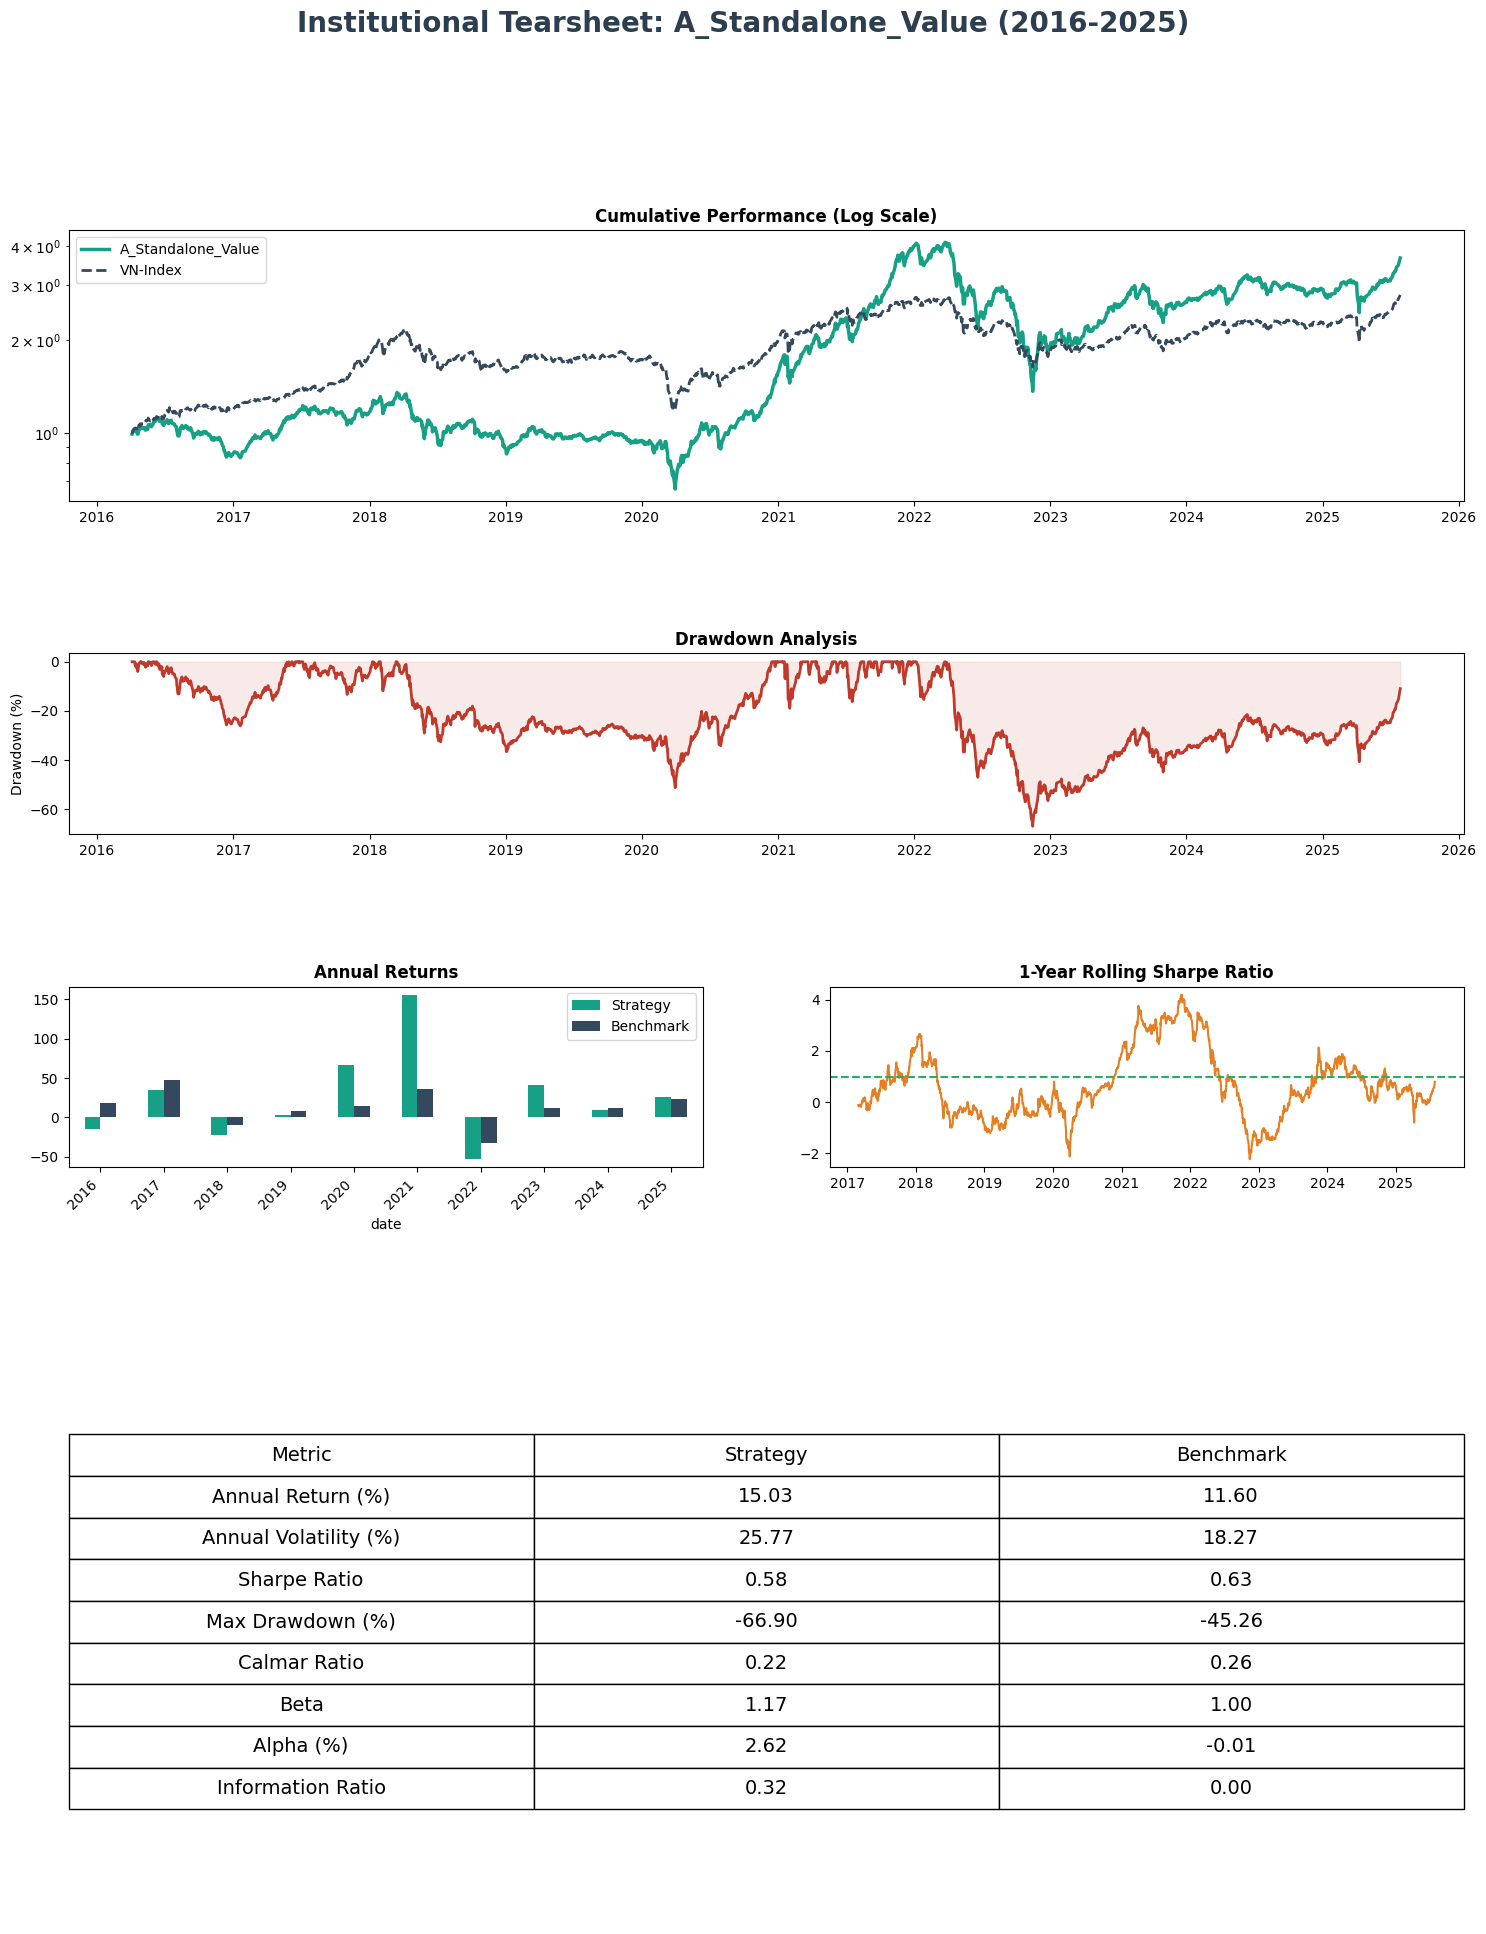


✅ Backtest for A_Standalone_Value complete.


In [5]:
# ============================================================================
# FINAL EXECUTION: CORRECTED BASELINE (P0 & P1 Fixes)
# This cell is self-contained to prevent scope errors.
# ============================================================================

# --- 1. Define All Necessary Variables ---

# Visualization Palette
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}

# Strategy Configurations
BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "transaction_cost_bps": 30,
}
ALL_CONFIGS = {
    "A_Standalone_Value": {
        **BASE_CONFIG,
        "strategy_name": "A_Standalone_Value",
        "factors_to_combine": {'Value_Composite': 1.0},
        "construction_method": "hybrid", # Use hybrid method
        "portfolio_size_small_universe": 20,
        "selection_percentile": 0.8
    }
}

# --- 2. Load All Data ---
# This function needs to be defined or accessible in this scope.
# Assuming it's in a cell above. If not, we should redefine it here.
factor_data_raw, daily_returns_matrix, benchmark_returns, engine = load_all_data(BASE_CONFIG)


# --- 3. Run the Backtest ---
print("\n" + "="*80)
print("🚀 RUNNING CORRECTED BASELINE: Standalone Value with P0 & P1 Fixes")
print("="*80)

# Use the 'A_Standalone_Value' config
corrected_baseline_config = ALL_CONFIGS['A_Standalone_Value']

# Instantiate the v2.2 backtester, passing the now-defined data and PALETTE
# (Ensure the UnifiedBacktester_v2_2 class is defined in a cell above)
corrected_baseline_backtester = UnifiedBacktester_v2_2(
    config=corrected_baseline_config,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine,
    palette=PALETTE
)

# Run the backtest and store the results
corrected_baseline_returns = corrected_baseline_backtester.run()

🚀 LAUNCHING BAKE-OFF RUN FOR: A_Standalone_Value
✅ UnifiedBacktester v2.2 initialized for strategy: 'A_Standalone_Value'
   - Data sliced to period: 2016-03-01 to 2025-07-28

--- Executing Backtest for: A_Standalone_Value ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 192.1B VND
  Market cap range: 199.2B - 156193.8B VND
  Adding sector

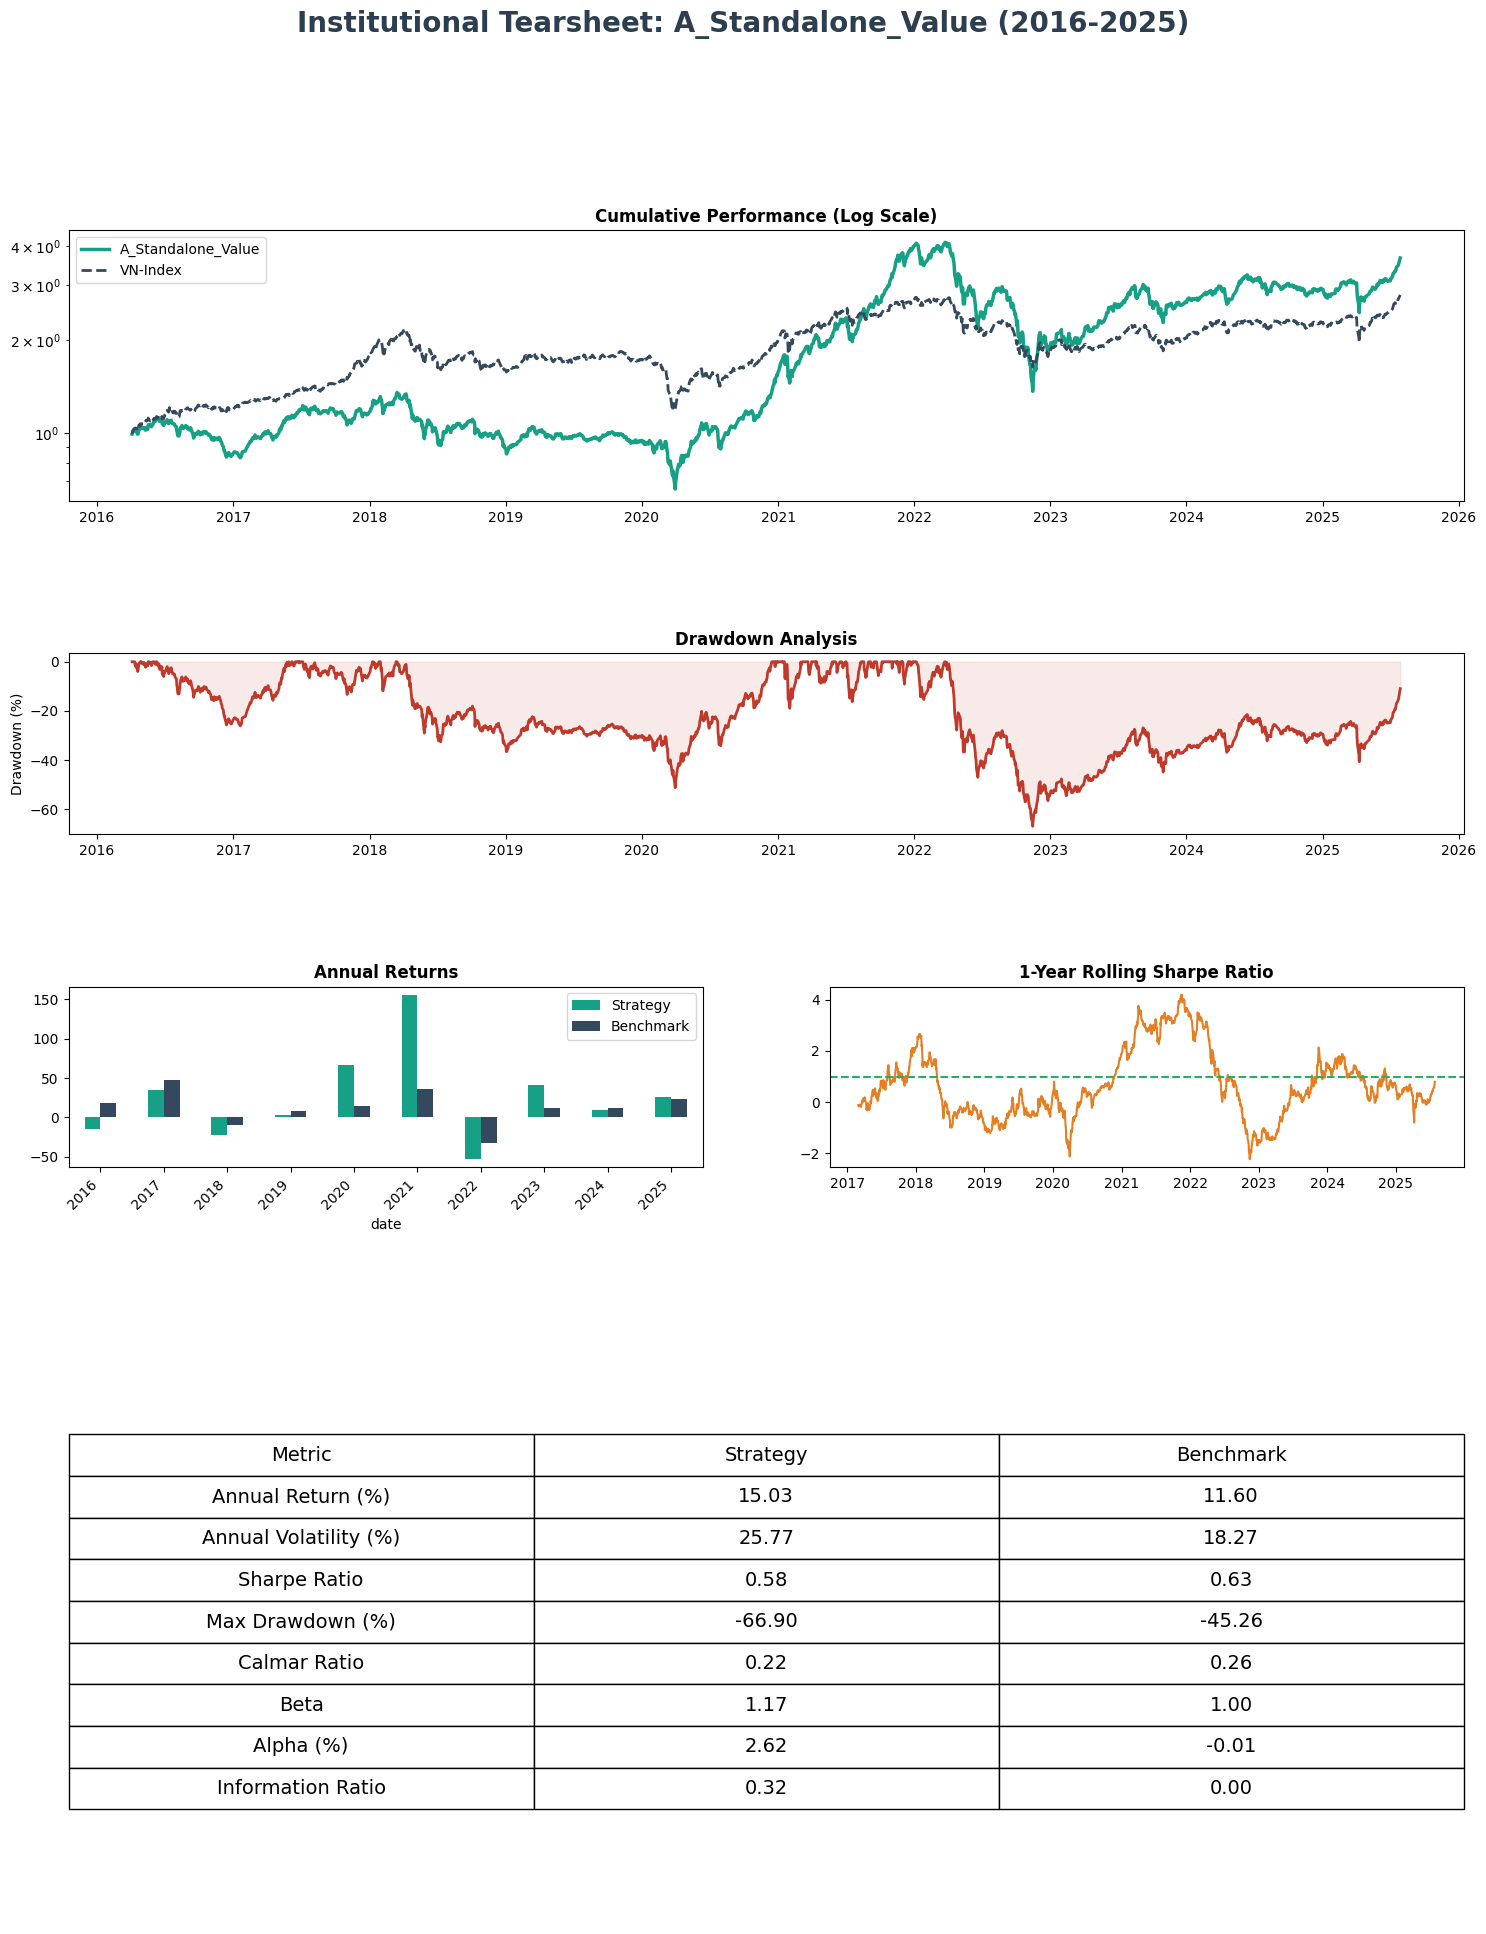


✅ Backtest for A_Standalone_Value complete.

✅ COMPLETED BAKE-OFF RUN FOR: A_Standalone_Value
🚀 LAUNCHING BAKE-OFF RUN FOR: B_Equal_Weighted_QVM
✅ UnifiedBacktester v2.2 initialized for strategy: 'B_Equal_Weighted_QVM'
   - Data sliced to period: 2016-03-01 to 2025-07-28

--- Executing Backtest for: B_Equal_Weighted_QVM ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe constructed: 

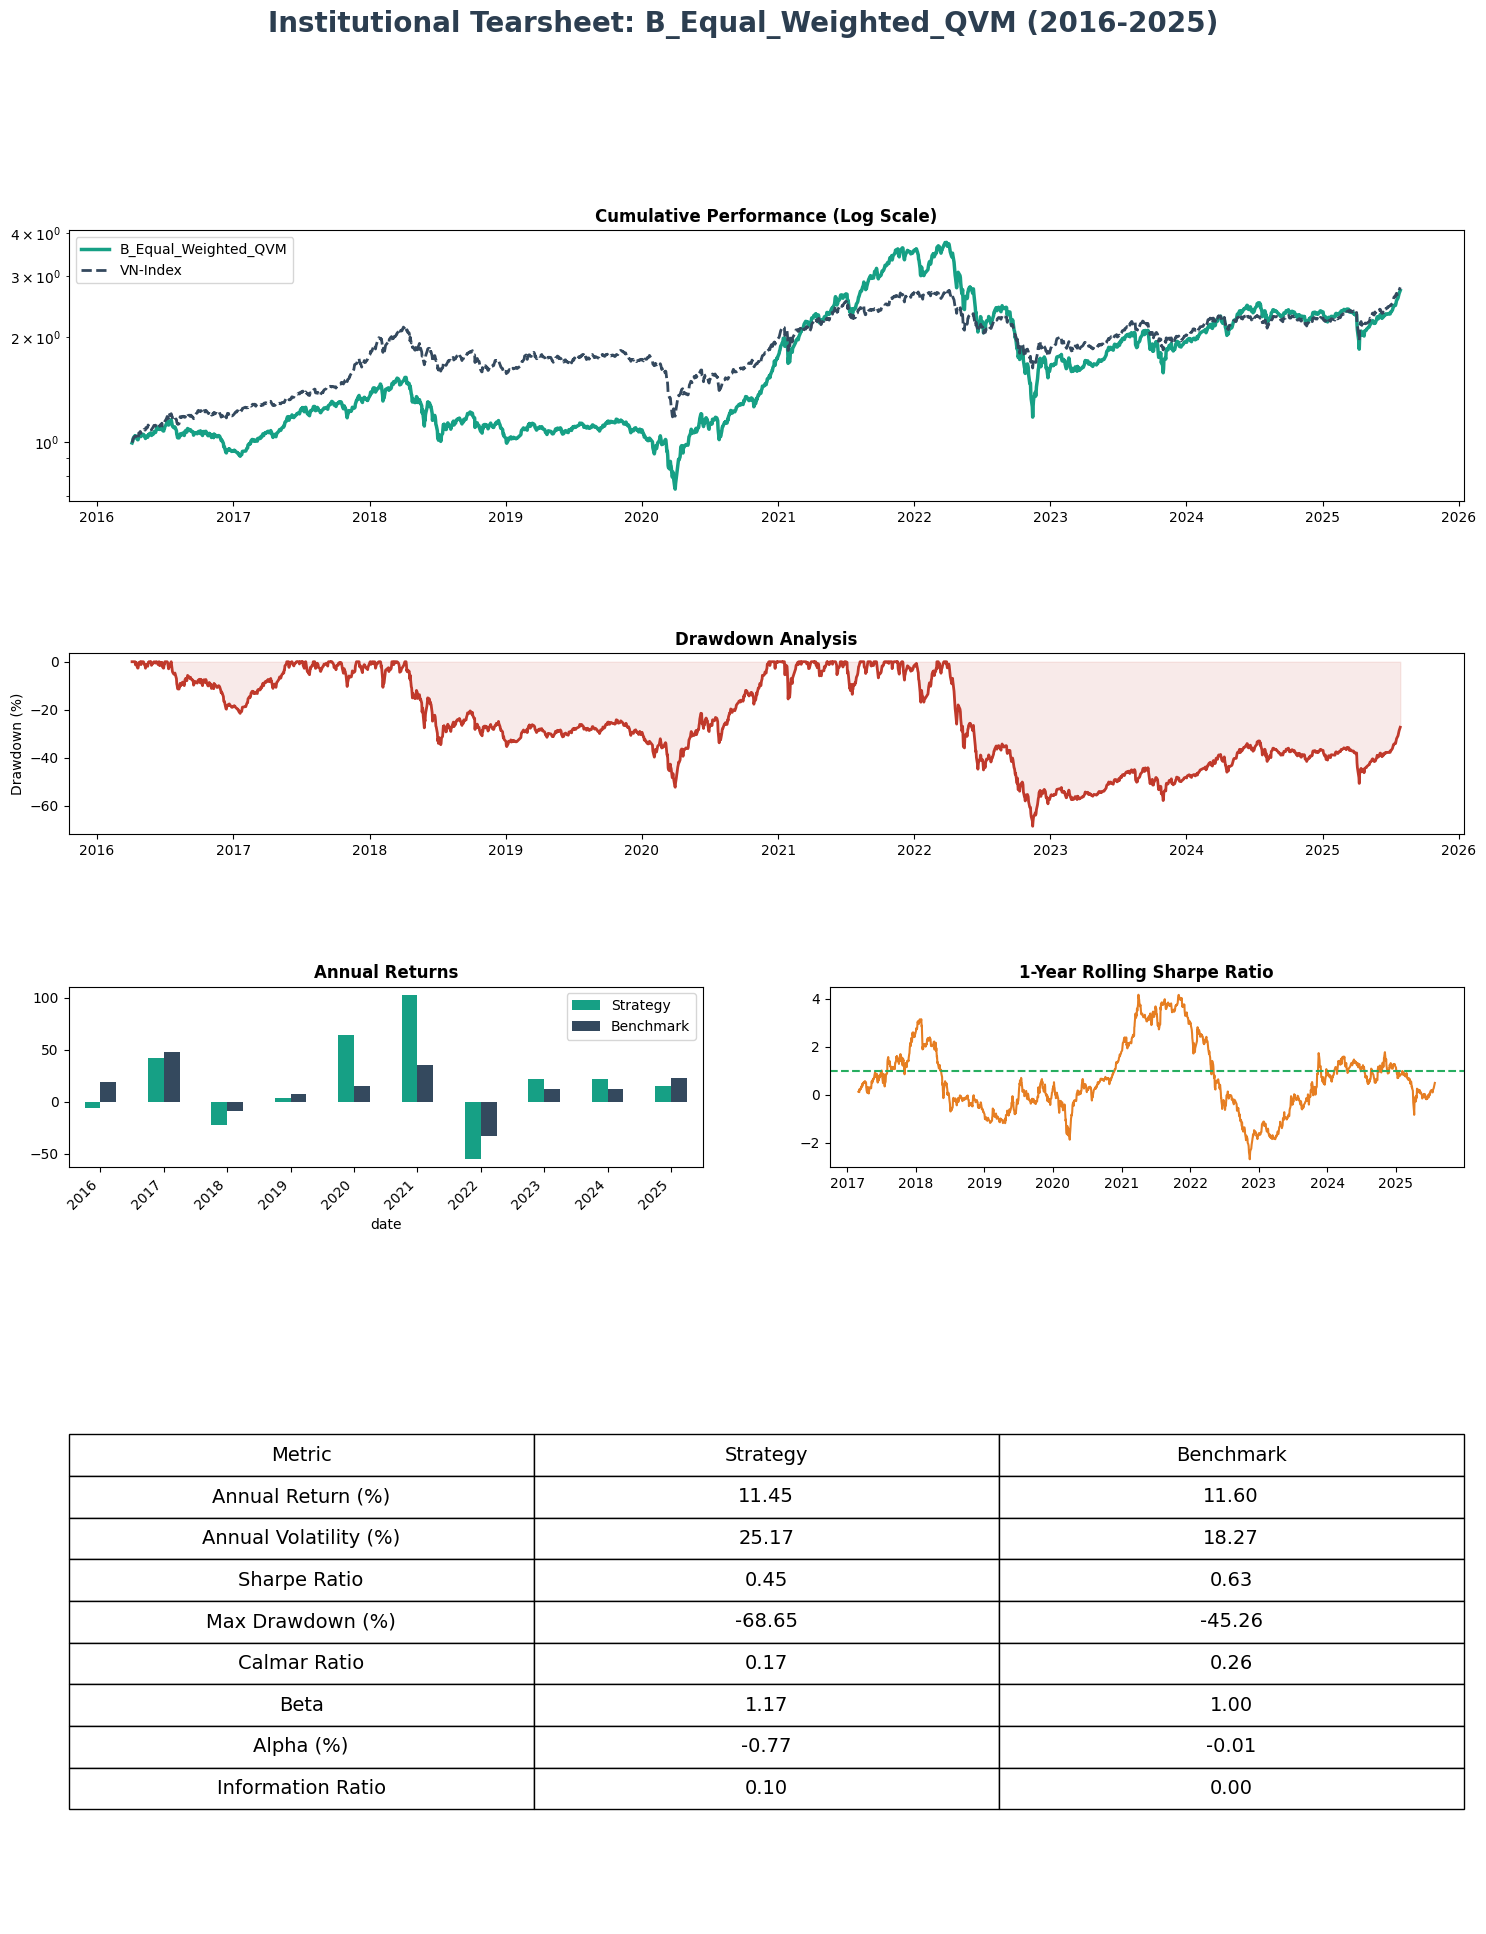


✅ Backtest for B_Equal_Weighted_QVM complete.

✅ COMPLETED BAKE-OFF RUN FOR: B_Equal_Weighted_QVM
🚀 LAUNCHING BAKE-OFF RUN FOR: C_Equal_Weighted_QVR
✅ UnifiedBacktester v2.2 initialized for strategy: 'C_Equal_Weighted_QVR'
   - Data sliced to period: 2016-03-01 to 2025-07-28

--- Executing Backtest for: C_Equal_Weighted_QVR ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe construct

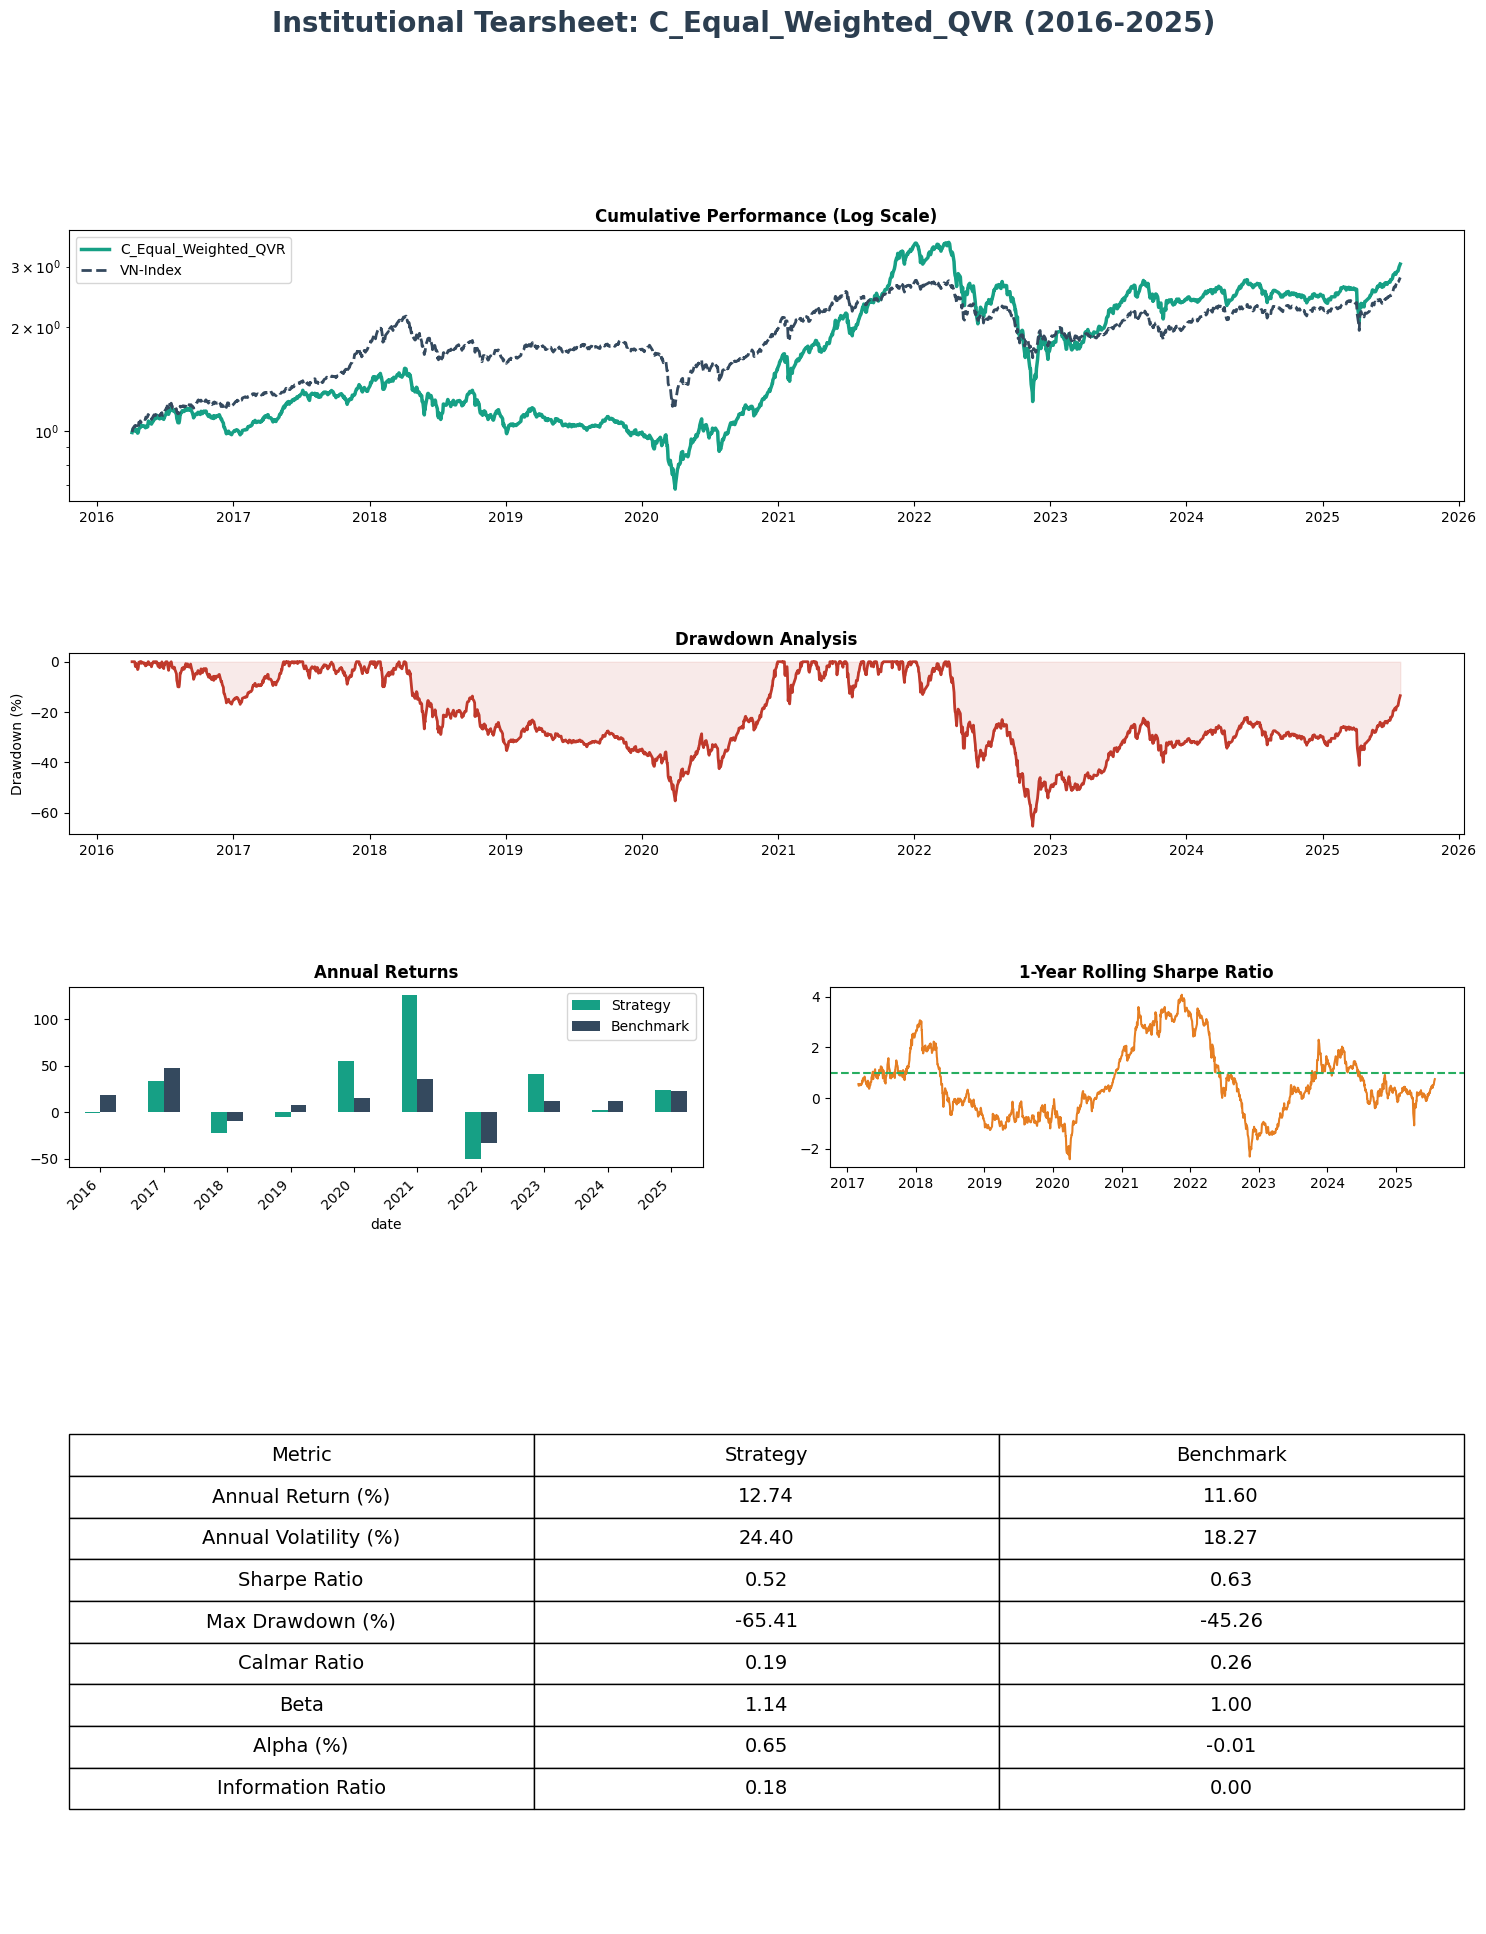


✅ Backtest for C_Equal_Weighted_QVR complete.

✅ COMPLETED BAKE-OFF RUN FOR: C_Equal_Weighted_QVR
🚀 LAUNCHING BAKE-OFF RUN FOR: D_Value_Weighted_QVM
✅ UnifiedBacktester v2.2 initialized for strategy: 'D_Value_Weighted_QVM'
   - Data sliced to period: 2016-03-01 to 2025-07-28

--- Executing Backtest for: D_Value_Weighted_QVM ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe construct

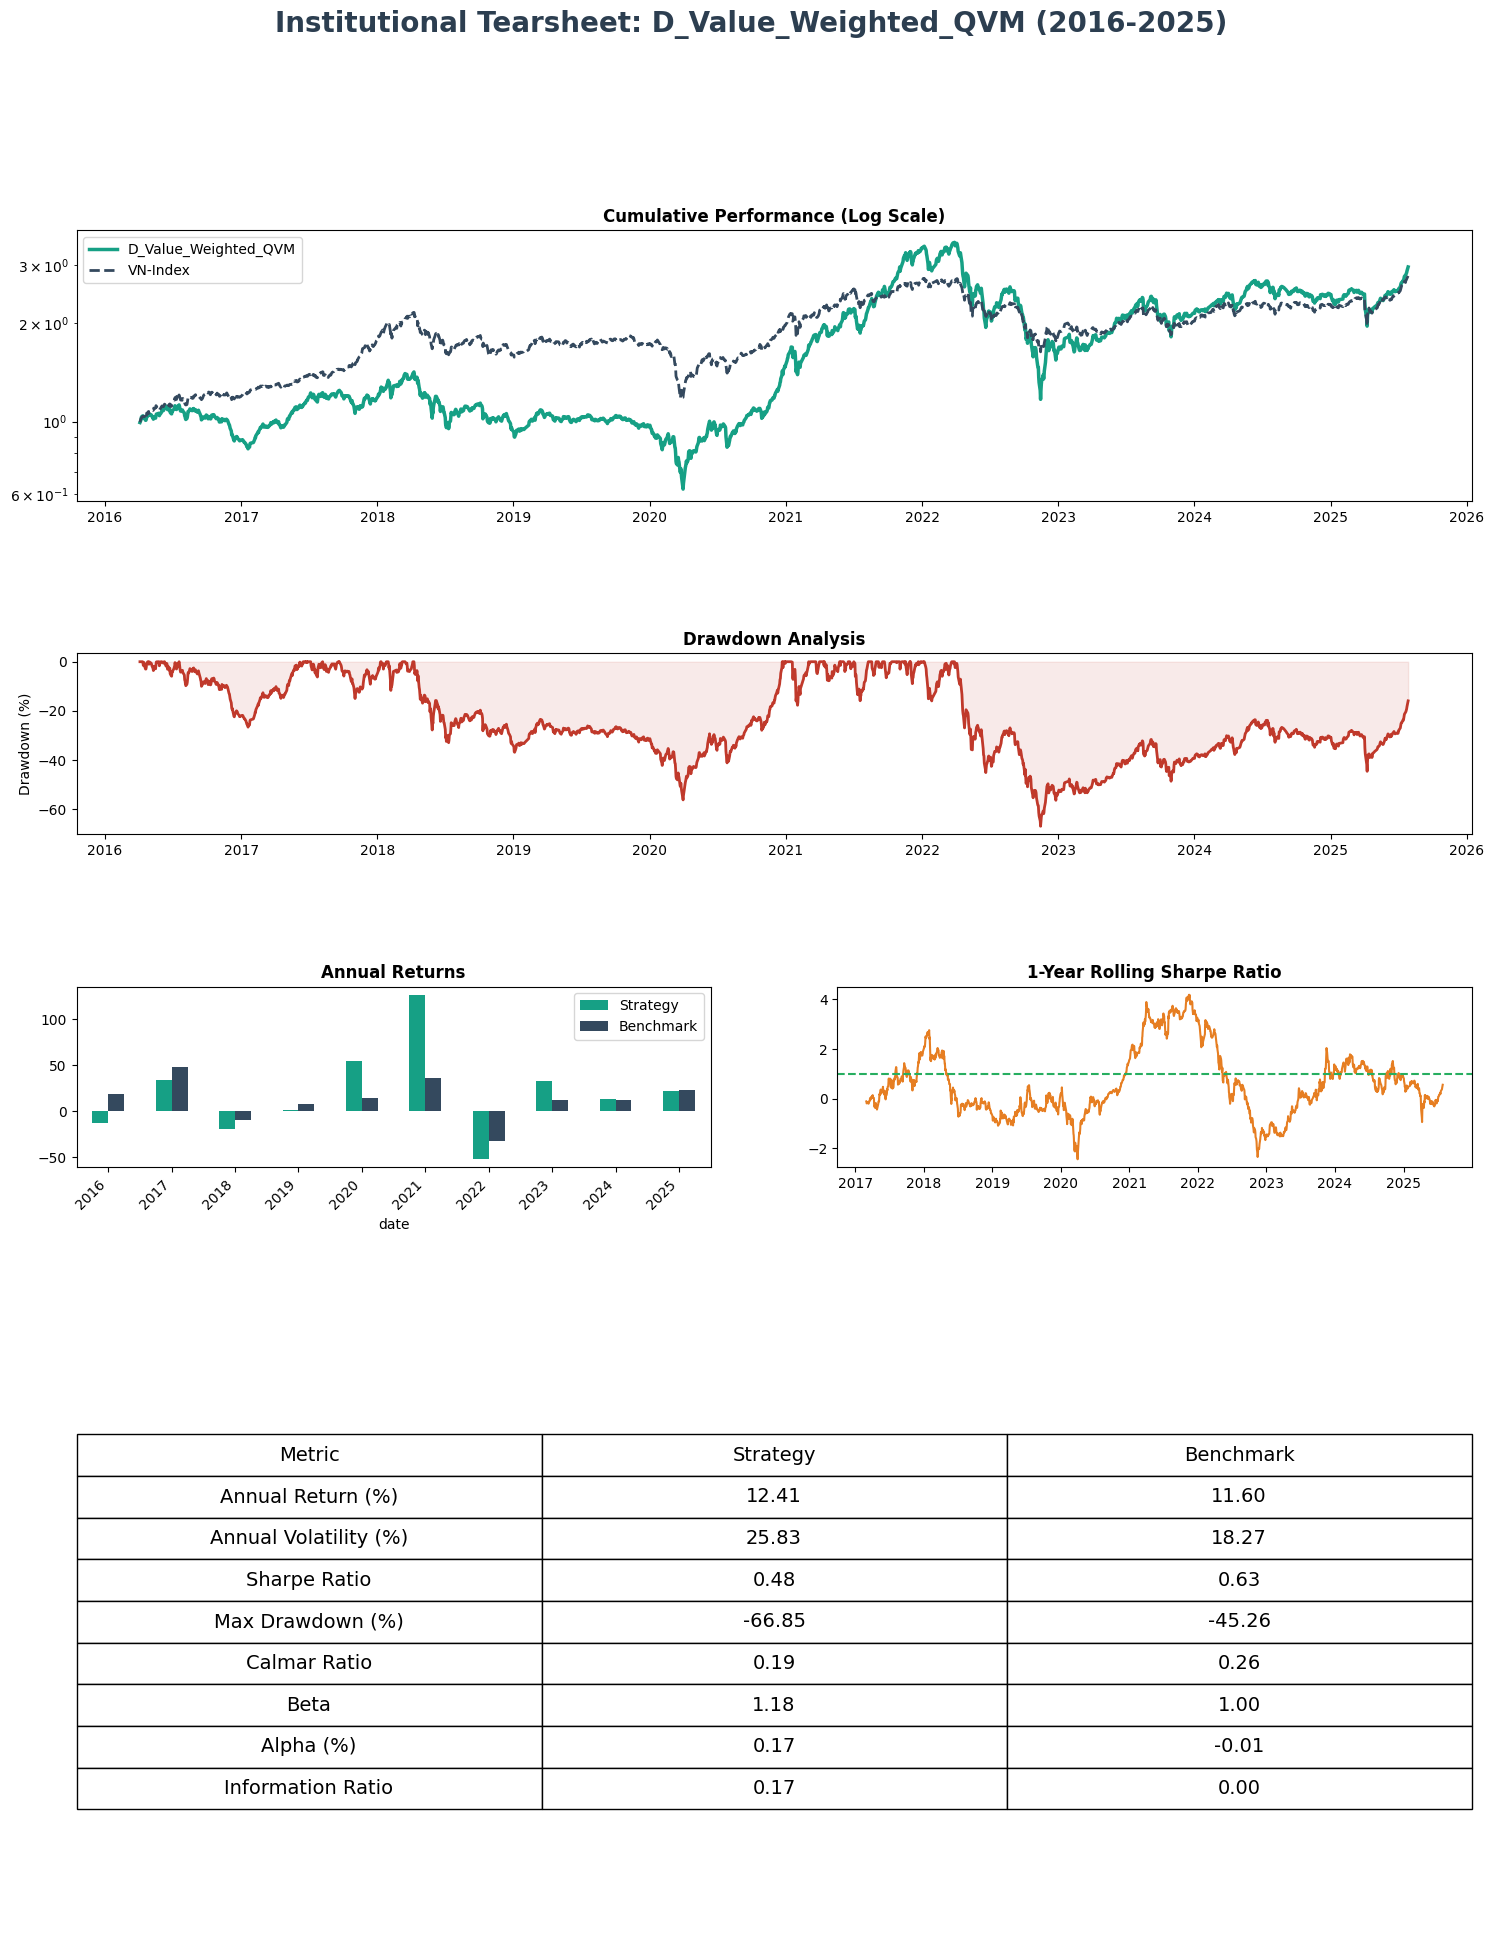


✅ Backtest for D_Value_Weighted_QVM complete.

✅ COMPLETED BAKE-OFF RUN FOR: D_Value_Weighted_QVM
🚀 LAUNCHING BAKE-OFF RUN FOR: E_Value_Weighted_QVR
✅ UnifiedBacktester v2.2 initialized for strategy: 'E_Value_Weighted_QVR'
   - Data sliced to period: 2016-03-01 to 2025-07-28

--- Executing Backtest for: E_Value_Weighted_QVR ---
   - Processing 2016-03-31... Constructing liquid universe for 2016-03-31...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 554 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 554
    Sample result: ('AAA', 41, 6.3474130902439025, 761.4546934536584)
    Before filters: 554 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-192.100B VND (need >= 10.0)
    Stocks passing trading days filter: 318
    Stocks passing ADTV filter: 63
    After filters: 62 stocks
✅ Universe construct

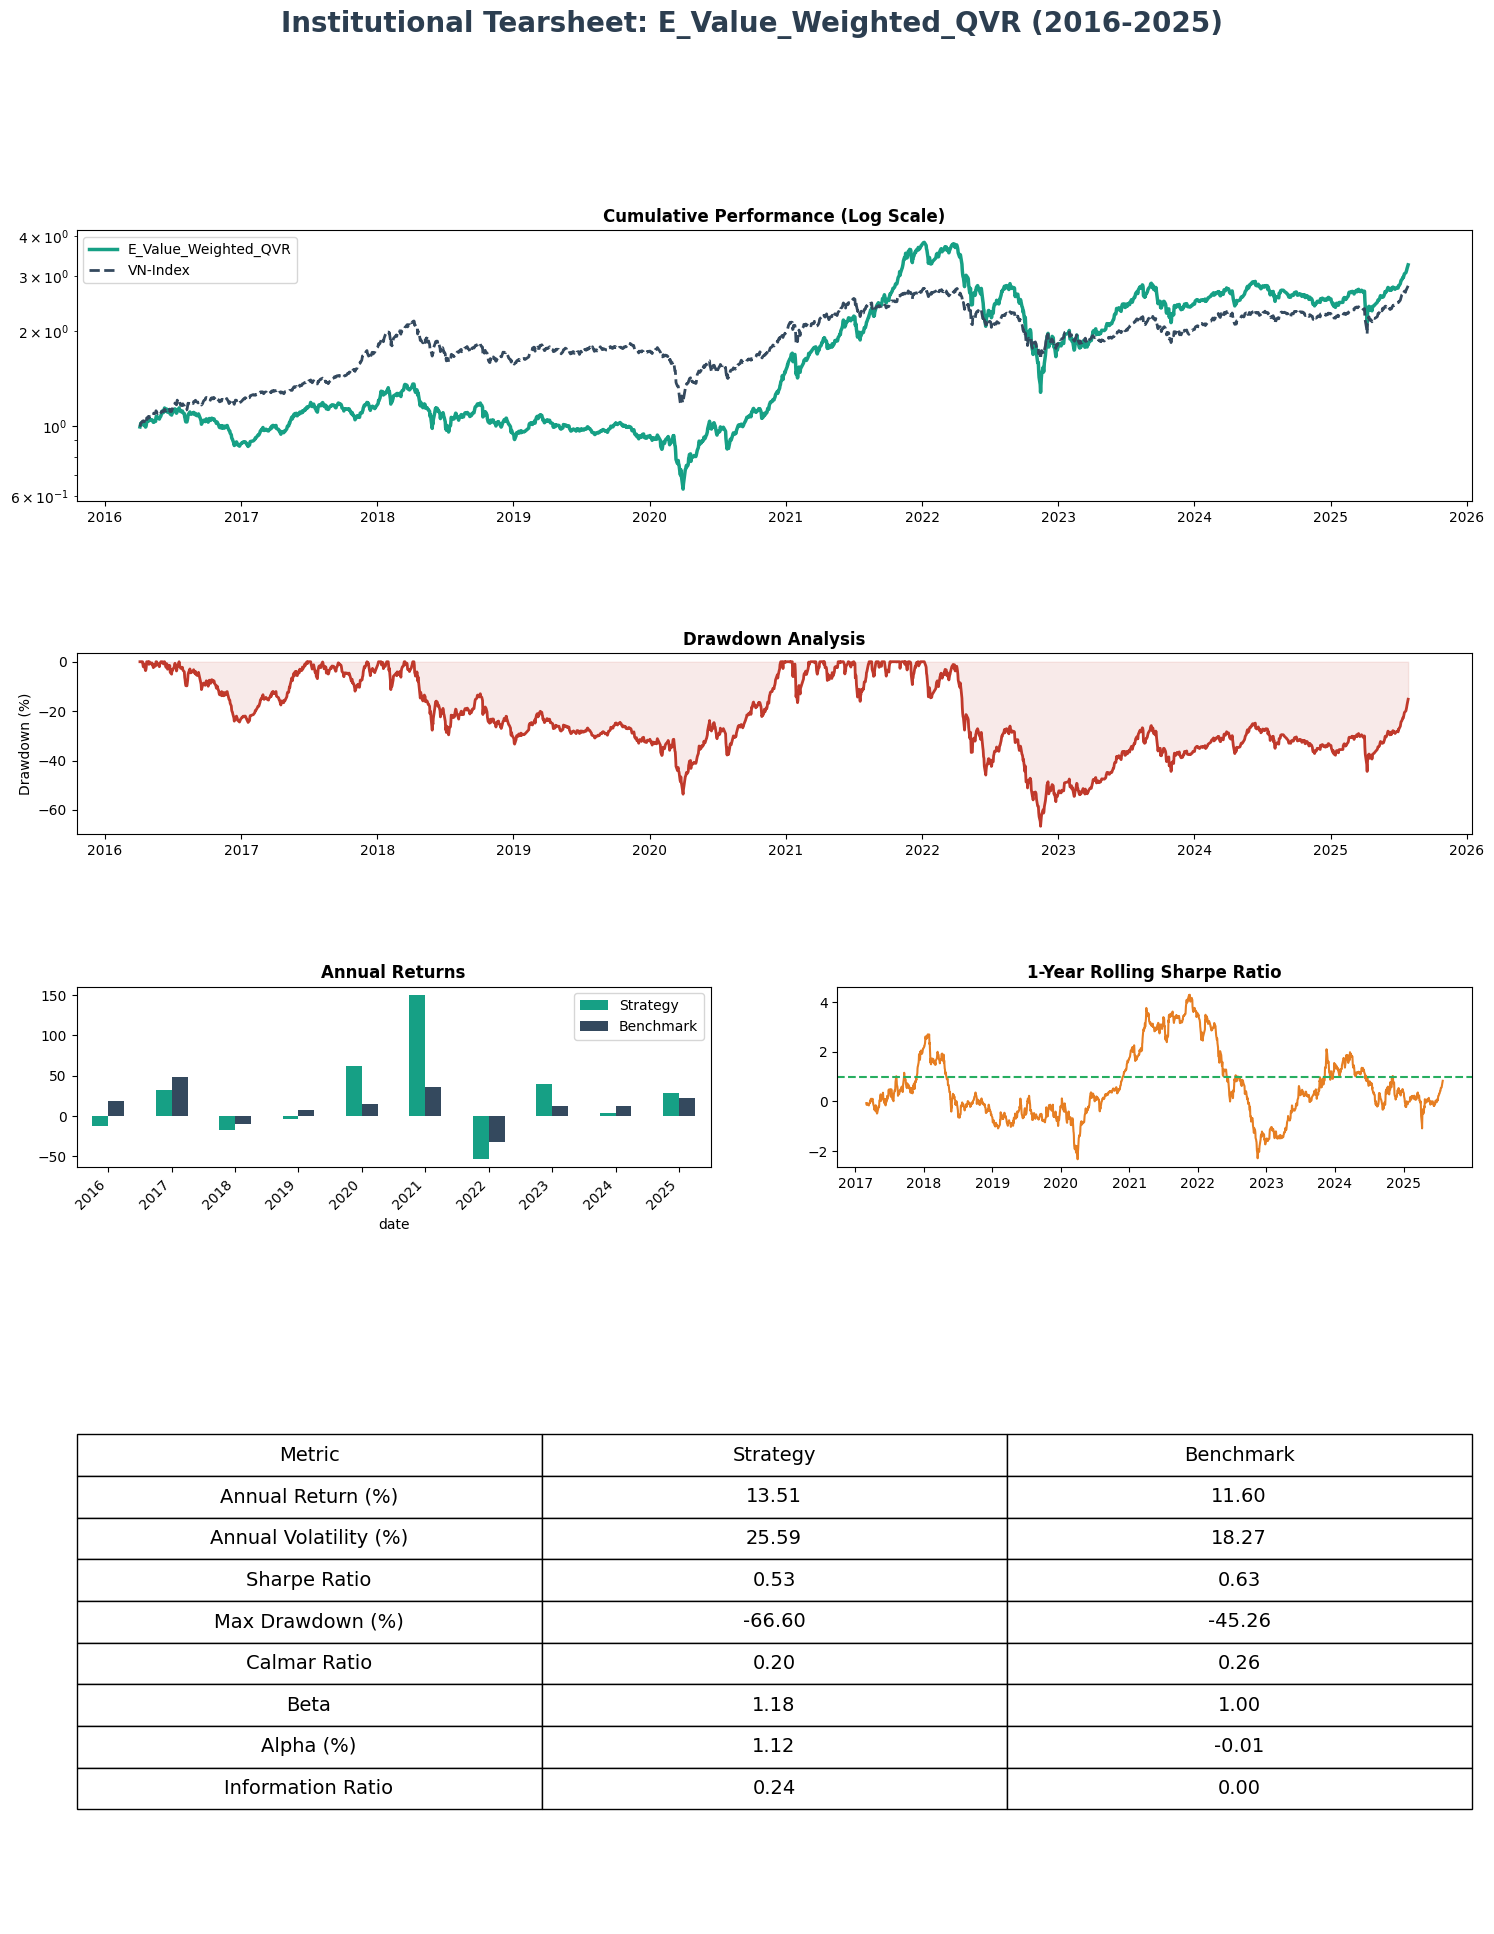


✅ Backtest for E_Value_Weighted_QVR complete.

✅ COMPLETED BAKE-OFF RUN FOR: E_Value_Weighted_QVR

🎉 ALL BAKE-OFF BACKTESTS COMPLETED.


--- FINAL BAKE-OFF PERFORMANCE SUMMARY ---


,Annual Return (%),Sharpe Ratio,Max Drawdown (%),Information Ratio,Alpha (%)
Strategy,,,,,
A_Standalone_Value,15.03,0.58,-66.90,0.32,2.62
B_Equal_Weighted_QVM,11.45,0.45,-68.65,0.10,-0.77
C_Equal_Weighted_QVR,12.74,0.52,-65.41,0.18,0.65
D_Value_Weighted_QVM,12.41,0.48,-66.85,0.17,0.17
E_Value_Weighted_QVR,13.51,0.53,-66.60,0.24,1.12


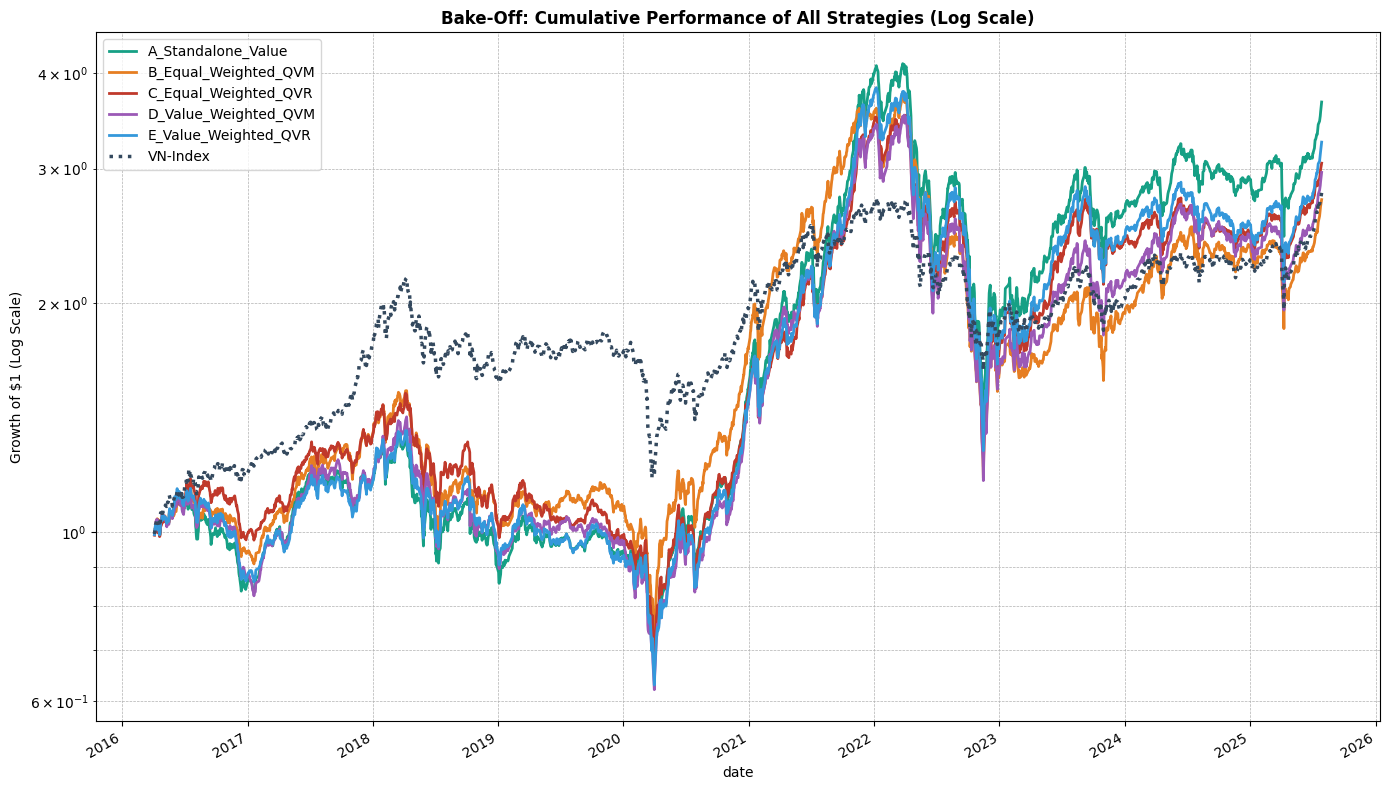

In [8]:
# ============================================================================
# FINAL EXECUTION: THE FULL FIVE-STRATEGY BAKE-OFF (DEFINITIVE VERSION)
# This cell is fully self-contained to prevent all scope errors.
# ============================================================================

# --- 1. Define All Configurations for the Bake-Off ---
# This ensures all CONFIG variables are in the local scope of this cell.
BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "strategy_version_db": "qvm_v2.0_enhanced",
    "transaction_cost_bps": 30,
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8
}
CONFIG_A = {**BASE_CONFIG, "strategy_name": "A_Standalone_Value", "factors_to_combine": {'Value_Composite': 1.0}}
CONFIG_B = {**BASE_CONFIG, "strategy_name": "B_Equal_Weighted_QVM", "factors_to_combine": {'Value_Composite': 1/3, 'Quality_Composite': 1/3, 'Momentum_Composite': 1/3}}
CONFIG_C = {**BASE_CONFIG, "strategy_name": "C_Equal_Weighted_QVR", "factors_to_combine": {'Value_Composite': 1/3, 'Quality_Composite': 1/3, 'Momentum_Reversal': 1/3}}
CONFIG_D = {**BASE_CONFIG, "strategy_name": "D_Value_Weighted_QVM", "factors_to_combine": {'Value_Composite': 0.6, 'Quality_Composite': 0.2, 'Momentum_Composite': 0.2}}
CONFIG_E = {**BASE_CONFIG, "strategy_name": "E_Value_Weighted_QVR", "factors_to_combine": {'Value_Composite': 0.6, 'Quality_Composite': 0.2, 'Momentum_Reversal': 0.2}}
ALL_CONFIGS_LIST = [CONFIG_A, CONFIG_B, CONFIG_C, CONFIG_D, CONFIG_E]


# --- 2. Store results for final comparison ---
bake_off_results = {}
all_returns_series = {}

# --- 3. Loop through each configuration and run a full backtest ---
for config in ALL_CONFIGS_LIST:
    print("="*80)
    print(f"🚀 LAUNCHING BAKE-OFF RUN FOR: {config['strategy_name']}")
    print("="*80)
    
    # Instantiate the v2.2 backtester
    # (Ensure the UnifiedBacktester_v2_2 class is defined in a cell above)
    backtester = UnifiedBacktester_v2_2(
        config=config,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine,
        palette=PALETTE
    )
    
    net_returns = backtester.run()
    
    # Store the results
    all_returns_series[config['strategy_name']] = net_returns
    bake_off_results[config['strategy_name']] = backtester._calculate_performance_metrics(net_returns)
    
    print(f"\n✅ COMPLETED BAKE-OFF RUN FOR: {config['strategy_name']}")

print("\n" + "="*80)
print("🎉 ALL BAKE-OFF BACKTESTS COMPLETED.")
print("="*80)

# --- 4. Final Summary Comparison ---
summary_df = pd.DataFrame(bake_off_results).T
summary_df.index.name = "Strategy"

print("\n\n--- FINAL BAKE-OFF PERFORMANCE SUMMARY ---")
display(summary_df[['Annual Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Information Ratio', 'Alpha (%)']].round(2))

# --- 5. Visualize the Equity Curves for a clear comparison ---
fig, ax = plt.subplots(figsize=(14, 8))

# Use a predefined color cycle for clarity
color_cycle = [PALETTE['primary'], PALETTE['highlight_2'], PALETTE['negative'], '#9B59B6', '#3498DB'] # Teal, Orange, Red, Purple, Blue

for i, (name, returns) in enumerate(all_returns_series.items()):
    first_trade = returns.loc[returns != 0].index.min()
    (1 + returns.loc[first_trade:]).cumprod().plot(ax=ax, label=name, color=color_cycle[i % len(color_cycle)], linewidth=2)

(1 + benchmark_returns.loc[first_trade:]).cumprod().plot(ax=ax, label='VN-Index', color=PALETTE['secondary'], linestyle=':', linewidth=2.5)

ax.set_title('Bake-Off: Cumulative Performance of All Strategies (Log Scale)', fontweight='bold')
ax.set_ylabel('Growth of $1 (Log Scale)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()